In [1]:
#Importing all the necessarry modules
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from pyimagesearch.preprocessing import MeanPreprocessor
from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import SimplePreprocessor
from pyimagesearch.io import HDF5DatasetGenerator
from pyimagesearch.nn.conv import DeeperGoogLeNet
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import h5py

In [2]:
TRAIN_HDF5 = "/media/pavle/HDD_disk/deep-learning/fruit-recognition/fruits-360_dataset/fruits-360/train.hdf5"
VAL_HDF5 = "/media/pavle/HDD_disk/deep-learning/fruit-recognition/fruits-360_dataset/fruits-360/validate.hdf5"
TEST_HDF5 = "/media/pavle/HDD_disk/deep-learning/fruit-recognition/fruits-360_dataset/fruits-360/test.hdf5"

In [3]:
#Loading Data.
with open("means.json", 'r') as j:
     means = json.loads(j.read())

mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()
sp = SimplePreprocessor(64,64)

batch_s = 64
#Initially ran on 75, tho on 45, the model reaches its maximum.
epochs = 45
#The dataset has this many classes, yes.
classes = 131

#Define data augmentationn.
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, fill_mode="nearest")

# initialize the training and validation dataset generators
trainGen = HDF5DatasetGenerator(TRAIN_HDF5, batch_s, aug=aug,
    preprocessors=[sp, mp, iap], classes=classes)
valGen = HDF5DatasetGenerator(VAL_HDF5, batch_s,
    preprocessors=[sp, mp, iap], classes=classes)
testGen = HDF5DatasetGenerator(TEST_HDF5, batch_s,
    preprocessors=[sp, mp, iap], classes=classes) 

In [4]:
model = DeeperGoogLeNet.build(width=64, height=64, depth=3, classes=classes, reg=0.0002)
opt = Adam(1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

2021-12-23 15:27:57.459039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 15:27:57.494467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 15:27:57.494757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 15:27:57.495357: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
H = model.fit_generator(
    trainGen.generator(),
    steps_per_epoch=trainGen.numImages // batch_s,
    validation_data=valGen.generator(),
    validation_steps=valGen.numImages // batch_s,
    epochs=epochs,
    max_queue_size=batch_s * 2,
    verbose=1)

/home/pavle/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-23 15:27:59.465037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/45


2021-12-23 15:28:04.188733: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-12-23 15:28:04.922530: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


793/793 [==============================] - 126s 147ms/step - loss: 1.8502 - accuracy: 0.8091 - val_loss: 19.3825 - val_accuracy: 0.0273
Epoch 2/45
793/793 [==============================] - 110s 136ms/step - loss: 1.2914 - accuracy: 0.9244 - val_loss: 11.0046 - val_accuracy: 0.1520
Epoch 3/45
793/793 [==============================] - 108s 136ms/step - loss: 0.9850 - accuracy: 0.9538 - val_loss: 5.5379 - val_accuracy: 0.4163
Epoch 4/45
793/793 [==============================] - 108s 137ms/step - loss: 0.8063 - accuracy: 0.9561 - val_loss: 7.0272 - val_accuracy: 0.3836
Epoch 5/45
793/793 [==============================] - 108s 137ms/step - loss: 0.6787 - accuracy: 0.9586 - val_loss: 3.3175 - val_accuracy: 0.5794
Epoch 6/45
793/793 [==============================] - 108s 137ms/step - loss: 0.5789 - accuracy: 0.9638 - val_loss: 2.7676 - val_accuracy: 0.6571
Epoch 7/45
793/793 [==============================] - 109s 137ms/step - loss: 0.5223 - accuracy: 0.9654 - val_loss: 3.6309 - val_accu

In [10]:
# save the model to file
print("[INFO] serializing model...")
model.save("model.hdf5", overwrite=True)

[INFO] serializing model...


In [6]:
# close the HDF5 datasets
trainGen.close()
valGen.close()

In [7]:
f = h5py.File(TEST_HDF5, 'r')
class_names = [x for x in os.listdir("/media/pavle/HDD_disk/deep-learning/fruit-recognition/fruits-360_dataset/fruits-360/Training/")]
testY = np.array(list(f["labels"]))
testY = np_utils.to_categorical(LabelEncoder().fit_transform(testY), len(class_names))

In [8]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testGen.generator(), steps=testGen.numImages // batch_s)

[INFO] evaluating network...


In [9]:
#Excluding 32 labels from testY because model.predict doesn't predict the last 32 samples. Don't know why.
print(classification_report(testY[:-32].argmax(axis=1), predictions.argmax(axis=1), target_names=class_names[:-1]))

                     precision    recall  f1-score   support

     Apple Braeburn       1.00      0.16      0.28       820
 Apple Crimson Snow       0.86      1.00      0.92       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.99      1.00      1.00       161
 Apple Granny Smith       1.00      1.00      1.00       164
    Apple Pink Lady       1.00      1.00      1.00       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       0.86      1.00      0.92       164
        Apple Red 3       1.00      0.78      0.88       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      1.00      1.00       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
            Avocado       0.18      1.00      0.30       143
       Avocado ripe    

/home/pavle/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pavle/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pavle/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pavle/.local/lib/python3.8/site-packages/skle

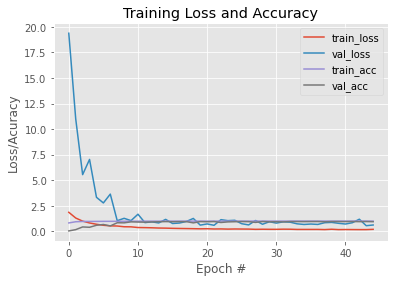

In [11]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Acuracy")
plt.legend()
plt.show()

In [12]:
testGen.close()